In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# prefix path
prefix = '/content/drive/MyDrive/DCC/cv/task2/mini'

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [ ]:
# tup
try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.83.188.58:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.83.188.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.83.188.58:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# 데이터 다운로드

> CIFAR-10은 32 x 32 크기의 60000개의 이미지로 이루어져 있습니다.
10개의 클래스로 분류(airplane, bird, cat ...) 되며 각각의 클래스는 6000개의 이미지로 이루어져 있습니다.
또, 5000개는 학습 데이터, 1000개는 테스트 데이터입니다
(총, 50000개의 학습 데이터, 10000개의 테스트 데이터).



In [ ]:
#데이터 셋
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
# dataset shape
print(train_images.shape, test_images.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


# 데이터 전처리


*   x는 255로 나누어 줘서 0에서 1사이로 변환시켜줌
*   y는 원 핫 인코딩을 적용함



In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, 
                                                  train_labels, 
                                                  test_size = 0.2, 
                                                  random_state=100)

In [ ]:
X_train.shape, X_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
# the number of classes
num_class = len(np.unique(Y_val))
num_class

10

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
test_images2 = test_images.astype('float32') / 255.0

In [ ]:
# make one-hot label
Y_train = keras.utils.to_categorical(Y_train)
Y_val = keras.utils.to_categorical(Y_val)
test_labels = keras.utils.to_categorical(test_labels)

# 데이터 Argumention

# 모델

In [45]:
with strategy.scope():
  # model
  model = keras.models.Sequential([
              keras.layers.Conv2D(filters = 32, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)),
              keras.layers.MaxPool2D(pool_size=(3, 3)),
              keras.layers.Conv2D(filters = 64 , kernel_size=(3, 3), activation='relu'),
              keras.layers.MaxPool2D(pool_size=(2, 2)),
              keras.layers.Flatten(),
              keras.layers.Dense(256, activation='relu'),
              keras.layers.Dense(num_class, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics='accuracy'
  )

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               147712    
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [49]:
# callback method

# checkpoint path
ckpt_name = 'CNN_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# if not exist, make dir
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # save model weights, at every epoch
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping, if val_loss is not improve five times
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1, 
        patience=5
    )
]

In [50]:
hist = model.fit(X_train, Y_train, validation_data=(X_val,Y_val),
                 callbacks=callbacks_list,
                 batch_size=200,
                 epochs=20)

Epoch 1/20
200/200 [==============================] - 8s 24ms/step - loss: 1.7608 - accuracy: 0.3614 - val_loss: 1.5593 - val_accuracy: 0.4174
Epoch 2/20
200/200 [==============================] - 3s 14ms/step - loss: 1.4383 - accuracy: 0.4849 - val_loss: 1.3540 - val_accuracy: 0.5215
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 1.3215 - accuracy: 0.5331 - val_loss: 1.2534 - val_accuracy: 0.5620
Epoch 4/20
200/200 [==============================] - 3s 14ms/step - loss: 1.2160 - accuracy: 0.5701 - val_loss: 1.1736 - val_accuracy: 0.5844
Epoch 5/20
200/200 [==============================] - 3s 14ms/step - loss: 1.1410 - accuracy: 0.6002 - val_loss: 1.1254 - val_accuracy: 0.6048
Epoch 6/20
200/200 [==============================] - 3s 13ms/step - loss: 1.0823 - accuracy: 0.6222 - val_loss: 1.0745 - val_accuracy: 0.6262
Epoch 7/20
200/200 [==============================] - 3s 14ms/step - loss: 1.0345 - accuracy: 0.6405 - val_loss: 1.0559 - val_accuracy: 0.6331

In [ ]:
# load last ckpt weight
model.load_weights(checkpoint_path)

In [54]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 6s 16ms/step - loss: 278.9913 - accuracy: 0.5243


[278.9913024902344, 0.5242999792098999]

# 결과확인하기

In [ ]:
y_pred = model.predict(X_val).round(2)

y_val_label = list(map(np.argmax, Y_val))
y_pred_label = list(map(np.argmax, y_pred))

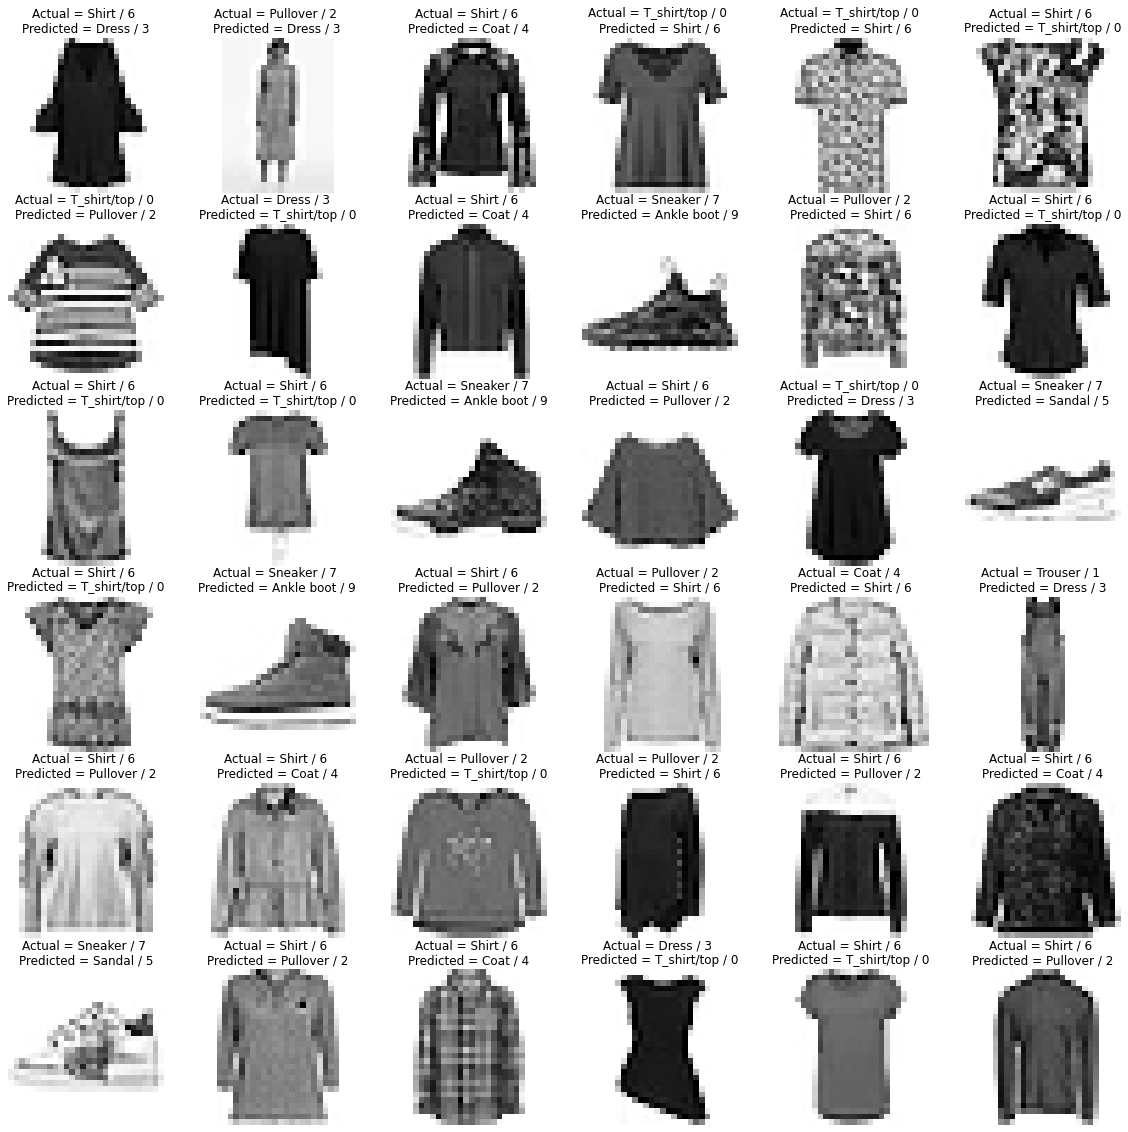

In [ ]:
aaa = np.array(y_val_label) != np.array(y_pred_label)
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               
not_equel_list = np.where(aaa == True)[0]

plt.figure(figsize=(20,20))
j = 1
for i in not_equel_list[0:36]:
# for a in np.random.randint(0,206,36):
#     i = not_equel_list[a]
#     print(a)
    plt.subplot(6,6,j); j+=1
    plt.imshow(X_val[i].reshape(28,28),cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_names[y_val_label[i]],
                                                            y_val_label[i],
                                                            class_names[y_pred_label[i]],
                                                            y_pred_label[i]))